In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
file_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/chartevents_neurology.csv'

# Load the CSV into a DataFrame
neurology = pd.read_csv(file_path)

# Display the first few rows to confirm it loaded correctly
print(neurology.head())

   subject_id   stay_id            charttime  itemid               value  \
0    10002428  38875437  2156-04-26 08:10:00  228096   0  Alert and calm   
1    10002428  38875437  2156-04-26 08:11:00  220739       Spontaneously   
2    10002428  38875437  2156-04-26 08:11:00  223900            Oriented   
3    10002428  38875437  2156-04-26 08:11:00  223901      Obeys Commands   
4    10002428  38875437  2156-04-26 12:00:00  220739       Spontaneously   

   valuenum  
0       0.0  
1       4.0  
2       5.0  
3       6.0  
4       4.0  


In [25]:
neurology.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207324 entries, 0 to 1207323
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   subject_id  1207324 non-null  int64  
 1   stay_id     1207324 non-null  int64  
 2   charttime   1207324 non-null  object 
 3   itemid      1207324 non-null  int64  
 4   value       1136100 non-null  object 
 5   valuenum    1207324 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 55.3+ MB


In [26]:
# Convert charttime to an datetime
neurology['charttime'] = neurology['charttime'].astype('datetime64[ns]')
neurology.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207324 entries, 0 to 1207323
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   subject_id  1207324 non-null  int64         
 1   stay_id     1207324 non-null  int64         
 2   charttime   1207324 non-null  datetime64[ns]
 3   itemid      1207324 non-null  int64         
 4   value       1136100 non-null  object        
 5   valuenum    1207324 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 55.3+ MB


In [27]:
# Load the d_items CSV
d_items_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/icu/d_items.csv'
d_items = pd.read_csv(d_items_path)

# Merge the label column into the ventilation dataframe using itemid
neurology = neurology.merge(
    d_items[['itemid', 'label']],
    on='itemid',
    how='left'  
)

In [28]:
neurology.head()

,subject_id,stay_id,charttime,itemid,value,valuenum,label
0,10002428,38875437,2156-04-26 08:10:00,228096,0 Alert and calm,0.0,Richmond-RAS Scale
1,10002428,38875437,2156-04-26 08:11:00,220739,Spontaneously,4.0,GCS - Eye Opening
2,10002428,38875437,2156-04-26 08:11:00,223900,Oriented,5.0,GCS - Verbal Response
3,10002428,38875437,2156-04-26 08:11:00,223901,Obeys Commands,6.0,GCS - Motor Response
4,10002428,38875437,2156-04-26 12:00:00,220739,Spontaneously,4.0,GCS - Eye Opening


In [29]:
neurology.shape

(1207324, 7)

In [30]:
# Group by itemid and count nulls in both 'value' and 'valuenum' columns
null_counts = neurology.groupby('itemid').agg(
    null_value=('value', lambda x: x.isnull().sum()),
    null_valuenum=('valuenum', lambda x: x.isnull().sum())
).reset_index()

null_counts

,itemid,null_value,null_valuenum
0,220739,71224,0
1,223900,0,0
2,223901,0,0
3,228096,0,0


In [31]:
# Load the d_items CSV
d_items_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/icu/d_items.csv'
d_items = pd.read_csv(d_items_path)

# Merge the label column with null_counts using itemid
null_counts = null_counts.merge(
    d_items[['itemid', 'label']],  
    on='itemid',
    how='left' 
)

null_counts

,itemid,null_value,null_valuenum,label
0,220739,71224,0,GCS - Eye Opening
1,223900,0,0,GCS - Verbal Response
2,223901,0,0,GCS - Motor Response
3,228096,0,0,Richmond-RAS Scale


In [32]:
# Group by itemid
grouped = neurology.groupby('itemid')

# Define the frequency function
def avg_obs_per_20_hours(group):
    n_obs = len(group)
    time_span_hours = (group['charttime'].max() - group['charttime'].min()).total_seconds() / 3600
    return (n_obs / time_span_hours * 20) if time_span_hours > 0 else float('nan')

# Apply the function to the cleaned dataframe
avg_freq_df = grouped.apply(avg_obs_per_20_hours).reset_index(name='avg_obs_per_20_hours')

/var/folders/ks/xzsx5z1n0zv653847sbsxy7r0000gp/T/ipykernel_57874/1591963204.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_freq_df = grouped.apply(avg_obs_per_20_hours).reset_index(name='avg_obs_per_20_hours')


In [33]:
avg_freq_df

,itemid,avg_obs_per_20_hours
0,220739,7.579810
1,223900,7.561433
2,223901,7.546085
3,228096,5.011251


In [34]:
# Check for outliers in the dataframe

summary_stats = neurology.groupby('itemid')['valuenum'].agg(
    min_value='min',
    max_value='max',
    median_value='median'
).reset_index()

# Load the d_items CSV
d_items_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/icu/d_items.csv'
d_items = pd.read_csv(d_items_path)

# Merge the label column with null_counts using itemid
summary_stats = summary_stats.merge(
    d_items[['itemid', 'label']],  
    on='itemid',
    how='left' 
)

print(summary_stats)

   itemid  min_value  max_value  median_value                  label
0  220739        1.0        4.0           3.0      GCS - Eye Opening
1  223900        1.0        5.0           1.0  GCS - Verbal Response
2  223901        1.0        6.0           6.0   GCS - Motor Response
3  228096       -5.0        4.0          -1.0     Richmond-RAS Scale


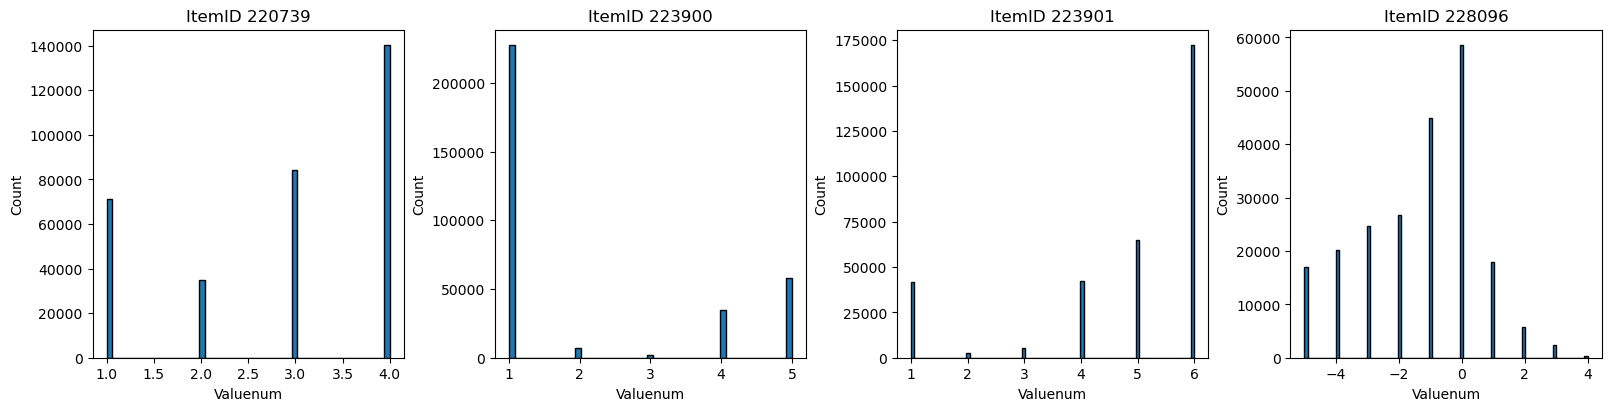

In [35]:
# Get unique itemids from vitals3
itemids = neurology['itemid'].unique()

# Filter NaNs in valuenum
filtered = neurology[neurology['valuenum'].notna() & neurology['itemid'].isin(itemids)]

# Group by itemid
grouped = filtered.groupby('itemid')['valuenum']

# Keep only non-empty groups
data_dict = {itemid: group for itemid, group in grouped if not group.empty}

# Plot configuration
n = len(data_dict)
cols = 4
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows), constrained_layout=True)
axes = axes.flatten()

# Plot histograms
for ax, (itemid, data) in zip(axes, data_dict.items()):
    ax.hist(data, bins='auto', edgecolor='black')
    ax.set_title(f'ItemID {itemid}')
    ax.set_xlabel('Valuenum')
    ax.set_ylabel('Count')

# Hide any unused subplots
for ax in axes[n:]:
    ax.set_visible(False)

plt.show()

In [36]:
file_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/postwean.csv'

# Load the CSV into a DataFrame
outcomes = pd.read_csv(file_path)

outcomes = outcomes[['subject_id', 'stay_id', 'ventilation_time', 'ext_success']]
outcomes = outcomes.drop_duplicates()
neurology = pd.merge(
    neurology,
    outcomes[['subject_id', 'stay_id', 'ext_success']],
    on=['subject_id', 'stay_id'],
    how='inner'  # 
)

In [37]:
neurology.head()

,subject_id,stay_id,charttime,itemid,value,valuenum,label,ext_success
0,10002428,38875437,2156-04-26 08:10:00,228096,0 Alert and calm,0.0,Richmond-RAS Scale,1
1,10002428,38875437,2156-04-26 08:11:00,220739,Spontaneously,4.0,GCS - Eye Opening,1
2,10002428,38875437,2156-04-26 08:11:00,223900,Oriented,5.0,GCS - Verbal Response,1
3,10002428,38875437,2156-04-26 08:11:00,223901,Obeys Commands,6.0,GCS - Motor Response,1
4,10002428,38875437,2156-04-26 12:00:00,220739,Spontaneously,4.0,GCS - Eye Opening,1


In [38]:
# Group by subject_id, stay_id, and itemid, count number of samples
group_counts = (
    neurology
    .groupby(['subject_id', 'stay_id', 'itemid'])
    .size()
    .reset_index(name='sample_count')
)

# Compute average sample count per itemid
avg_samples = (
    group_counts
    .groupby('itemid')['sample_count']
    .mean()
    .reset_index(name='avg_samples_per_subject_stay')
)

# If 'label' exists and is associated uniquely with itemid, merge it in
if 'label' in neurology.columns:
    itemid_label_map = neurology[['itemid', 'label']].drop_duplicates()
    avg_samples = avg_samples.merge(itemid_label_map, on='itemid', how='left')

# Reorder columns if needed
avg_samples = avg_samples[['itemid', 'label', 'avg_samples_per_subject_stay']] if 'label' in avg_samples.columns else avg_samples

In [39]:
avg_samples

,itemid,label,avg_samples_per_subject_stay
0,220739,GCS - Eye Opening,66.360639
1,223900,GCS - Verbal Response,66.200034
2,223901,GCS - Motor Response,66.062373
3,228096,Richmond-RAS Scale,53.788788


In [40]:
neurology1 = neurology.copy()

In [41]:
# As feature windows need to be the same length, I will isolate the last 24h of each subject_id and stay_id combination

from datetime import timedelta

file_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/postwean.csv'

# Load the CSV into a DataFrame
outcomes = pd.read_csv(file_path)

# Ensure datetime formats
for col in ['ventilation_endtime', 'extubation_time', 'deathtime']:
    outcomes[col] = pd.to_datetime(outcomes[col])
neurology1['charttime'] = pd.to_datetime(neurology1['charttime'])

# Create an empty list to hold the filtered results
neurology1_parts = []

# Optional: tqdm for progress tracking (pip install tqdm if needed)
from tqdm import tqdm

# Group outcomes by subject_id and stay_id
grouped_outcomes = outcomes.groupby(['subject_id', 'stay_id'])

# Loop through each unique patient-stay combination
for (subject_id, stay_id), group in tqdm(grouped_outcomes, total=len(grouped_outcomes)):

    # Get the latest of the 3 possible times
    reference_time = pd.to_datetime(
        group[['ventilation_endtime', 'extubation_time', 'deathtime']].max(axis=1).iloc[0]
    )
    
    if pd.isnull(reference_time):
        continue  # skip if no valid time

    # Filter ventilation5 for the same subject/stay in the 24h window
    mask = (
        (neurology1['subject_id'] == subject_id) &
        (neurology1['stay_id'] == stay_id) &
        (neurology1['charttime'] >= reference_time - timedelta(hours=24)) &
        (neurology1['charttime'] <= reference_time)
    )
    filtered = neurology1[mask]

    if not filtered.empty:
        neurology1_parts.append(filtered)

# Combine all filtered chunks
neurology1 = pd.concat(neurology1_parts, ignore_index=True)

100%|██████████████████████████████████████| 5884/5884 [00:39<00:00, 149.07it/s]


In [42]:
neurology1.head()

,subject_id,stay_id,charttime,itemid,value,valuenum,label,ext_success
0,10002428,38875437,2156-04-21 20:00:00,228096,-1 Awakens to voice (eye opening/contact) > 10...,-1.0,Richmond-RAS Scale,1
1,10002428,38875437,2156-04-21 20:00:00,220739,To Speech,3.0,GCS - Eye Opening,1
2,10002428,38875437,2156-04-21 20:00:00,223900,No Response-ETT,1.0,GCS - Verbal Response,1
3,10002428,38875437,2156-04-21 20:00:00,223901,Obeys Commands,6.0,GCS - Motor Response,1
4,10002428,38875437,2156-04-22 00:00:00,220739,To Speech,3.0,GCS - Eye Opening,1


In [43]:
neurology1 = neurology1[['subject_id', 'stay_id', 'charttime', 'valuenum', 'itemid', 'label', 'ext_success']]

In [44]:
import os

neurology1.to_csv("/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/neurology_cleaned_combi.csv", index=False)